# Análise Estatística de Dados e Informações
**PPCA/UNB**

---

**Tarefa 01 - Distribuição da Probabilidade e Simulação de Monte Carlo**  
**Professor**: João Gabriel de Moraes Sousa  
**Aluna**: Andreia Queiroz Correia Dummar  
**Matrícula**: 241134680  
**Data da Entrega**: 10/11/2024  
**Github**: https://github.com/aqcorreia/AEDI/tree/4d5e4ca741e1c244b96bb5331695dfcf254dc324/Tarefa01

---

**Aplicação**: Análise da distribuição pluviométrica anual no Distrito Federal  

**Dados**: [SNIRH - Séries Históricas](https://www.snirh.gov.br/hidroweb/serieshistoricas)  
**Filtros**: Estado = Distrito Federal

---

Apesar da análise descritiva dos dados indicar uma distribuição Log-normal ou Gama, este trabalho também realizou a simulação de Monte Carlo considerando a distribuição Normal para ampliar o conhecimento.

A partir das simulações de Monte Carlo com as três distribuições (**Log-Normal**, **Gama** e **Normal**), foram utilizadas as seguintes **métricas de avaliação** para verificar qual melhor se adequava aos dados utilizados:

- **Log-Likelihood (Log-Verossimilhança)**:  
  Mede o quão bem uma distribuição ajusta os dados observados. Essa métrica calcula a probabilidade de observar os dados com base nos parâmetros da distribuição ajustada. Quanto maior a log-verossimilhança, melhor a distribuição representa os dados, indicando uma probabilidade mais alta de observar os dados sob aquela distribuição ajustada.

- **AIC (Akaike Information Criterion) e BIC (Bayesian Information Criterion)**:  
  São métricas que avaliam o ajuste de um modelo enquanto penalizam sua complexidade (ou seja, o número de parâmetros). Ambas são baseadas na log-verossimilhança. Quanto menores os valores de AIC e BIC, melhor o ajuste ao equilíbrio entre precisão e simplicidade do modelo. O BIC penaliza modelos complexos mais fortemente que o AIC, sendo mais adequado em análises onde se deseja modelos mais simples.

- **Teste de Kolmogorov-Smirnov (K-S Test)**:  
  O teste de Kolmogorov-Smirnov é um teste não paramétrico que compara a distribuição dos dados observados com a distribuição teórica ajustada. Ele calcula a maior diferença (estatística \( D \)) entre as duas distribuições:
  
  - Um valor de \( D \) menor indica uma diferença menor entre a distribuição dos dados e a distribuição ajustada, sugerindo um ajuste melhor.
  - Um valor de \( p \) alto (geralmente > 0.05) indica que a distribuição ajustada não é significativamente diferente dos dados, o que sugere que o ajuste é adequado.


## 1. Carga dos dados

In [3]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import lognorm
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import kstest
import warnings

In [4]:
# Diretório onde estão os arquivos CSV
diretorio_dados = "./Dados"

# Listando todos os arquivos CSV no diretório especificado
arquivos_csv = glob.glob(os.path.join(diretorio_dados, "*.csv"))

# Lendo e concatenando todos os arquivos CSV em um único DataFrame
df_chuvas = pd.concat((pd.read_csv(f, encoding='latin1', delimiter=';', decimal=',') for f in arquivos_csv), ignore_index=True)

# Exibindo as primeiras linhas do DataFrame combinado
df_chuvas.head()



,EstacaoCodigo,NivelConsistencia,Data,TipoMedicaoChuvas,Maxima,Total,DiaMaxima,NumDiasDeChuva,MaximaStatus,TotalStatus,...,Chuva22Status,Chuva23Status,Chuva24Status,Chuva25Status,Chuva26Status,Chuva27Status,Chuva28Status,Chuva29Status,Chuva30Status,Chuva31Status
0,1547002,1,01/04/2013,1,NaN,NaN,NaN,NaN,0,0,...,1,1,1,1,0,0,0,0.0,0.0,0.0
1,1547002,1,01/03/2013,1,31.6,144.8,21.0,8.0,1,1,...,1,1,1,1,1,1,1,1.0,1.0,1.0
2,1547002,1,01/02/2013,1,33.4,129.0,1.0,10.0,1,1,...,1,1,1,1,1,1,1,0.0,0.0,0.0
3,1547002,1,01/01/2013,1,72.3,408.2,10.0,20.0,1,1,...,1,1,1,1,1,1,1,1.0,1.0,1.0
4,1547002,2,01/12/2012,1,23.8,137.5,15.0,16.0,1,1,...,1,1,1,1,1,1,1,1.0,1.0,1.0


## 2. Tratamento e análise descritiva dos dados

In [6]:
df_chuvas.shape

(2560, 75)

In [7]:
import pandas as pd

# Certifique-se de que a coluna 'Data' está no formato datetime
df_chuvas['Data'] = pd.to_datetime(df_chuvas['Data'], format='%d/%m/%Y', errors='coerce')

# Extrair o ano da coluna 'Data' para facilitar a análise
df_chuvas['Ano'] = df_chuvas['Data'].dt.year

# Agrupar por 'EstacaoCodigo' e calcular total de registros, menor ano e maior ano
resumo_estacoes = df_chuvas.groupby('EstacaoCodigo').agg(
    total_registros=('Data', 'count'),
    menor_ano=('Ano', 'min'),
    maior_ano=('Ano', 'max')
).reset_index()

# Exibindo o resultado
resumo_estacoes.head()


,EstacaoCodigo,total_registros,menor_ano,maior_ano
0,1547002,827,1973,2013
1,1547004,752,1961,2024
2,1547006,344,1961,1990
3,1547008,637,1971,2024


In [8]:
# Salvando o DataFrame df_chuvas em um arquivo CSV
df_chuvas.to_csv('./Dados/Consolidado/df_chuvas_combinado.csv', index=False, encoding='latin1', sep=';')


In [9]:
# Verificando o total de registros por cada tipo na coluna 'NivelConsistencia'
total_por_nivel = df_chuvas['NivelConsistencia'].value_counts()

# Exibindo o resultado
print(total_por_nivel)


NivelConsistencia
1    2207
2     353
Name: count, dtype: int64


In [10]:
# Verificação da qtde TotalStatus seja maior que 2
# Status: 0 = Branco, 1 = Real, 2 = Estimado, 3 = Duvidoso, 4 = Acumulado

# Verificando o total de registros por cada tipo na coluna 'NivelConsistencia'
total_por_nivel = df_chuvas['TotalStatus'].value_counts()

# Exibindo o resultado
print(total_por_nivel)

TotalStatus
1    2452
2      94
0       8
3       6
Name: count, dtype: int64


In [11]:
# Removendo registros com valores de 'TotalStatus' maiores que 2
df_chuvas = df_chuvas[df_chuvas['TotalStatus'] <= 2]

# Exibindo as primeiras linhas do DataFrame para confirmar
df_chuvas.shape


(2554, 76)

In [12]:
# Contando registros onde tanto 'Maxima' quanto 'Total' são NaN
total_nan = df_chuvas[df_chuvas['Maxima'].isna() | df_chuvas['Total'].isna()].shape[0]

# Exibindo o total
print(f"Total de registros onde 'Maxima' e 'Total' são NaN: {total_nan}")


Total de registros onde 'Maxima' e 'Total' são NaN: 109


In [13]:
# Removendo registros onde tanto 'Maxima' quanto 'Total' são NaN
df_chuvas = df_chuvas[~(df_chuvas['Maxima'].isna() | df_chuvas['Total'].isna())]

# Exibindo as primeiras linhas do DataFrame para confirmar a remoção
df_chuvas.shape


(2445, 76)

In [14]:
# Certifique-se de que a coluna 'Data' está no formato datetime
df_chuvas['Data'] = pd.to_datetime(df_chuvas['Data'], format='%d/%m/%Y', errors='coerce')

# Criando as colunas 'Ano' e 'Mes' a partir da coluna 'Data'
df_chuvas['Ano'] = df_chuvas['Data'].dt.year
df_chuvas['Mes'] = df_chuvas['Data'].dt.month

# Selecionando apenas as colunas desejadas
df_chuvas_analise = df_chuvas[['Data', 'Maxima', 'Total', 'EstacaoCodigo', 'Ano', 'Mes']]

# Exibindo as primeiras linhas do novo DataFrame
df_chuvas_analise.head()


,Data,Maxima,Total,EstacaoCodigo,Ano,Mes
1,2013-03-01,31.6,144.8,1547002,2013,3
2,2013-02-01,33.4,129.0,1547002,2013,2
3,2013-01-01,72.3,408.2,1547002,2013,1
4,2012-12-01,23.8,137.5,1547002,2012,12
5,2012-12-01,23.8,137.5,1547002,2012,12


                                Data       Maxima        Total  EstacaoCodigo  \
count                           2445  2445.000000  2445.000000   2.445000e+03   
mean   1991-08-19 23:21:07.730061312    30.552679   114.680429   1.547005e+06   
min              1961-01-01 00:00:00     0.000000     0.000000   1.547002e+06   
25%              1978-06-01 00:00:00     6.600000     9.900000   1.547002e+06   
50%              1990-03-01 00:00:00    28.400000    86.500000   1.547004e+06   
75%              2004-11-01 00:00:00    46.900000   191.500000   1.547008e+06   
max              2024-04-01 00:00:00   145.000000   571.600000   1.547008e+06   
std                              NaN    25.785818   112.671992   2.349419e+00   

               Ano          Mes  
count  2445.000000  2445.000000  
mean   1991.175460     6.501840  
min    1961.000000     1.000000  
25%    1978.000000     4.000000  
50%    1990.000000     7.000000  
75%    2004.000000     9.000000  
max    2024.000000    12.000000 

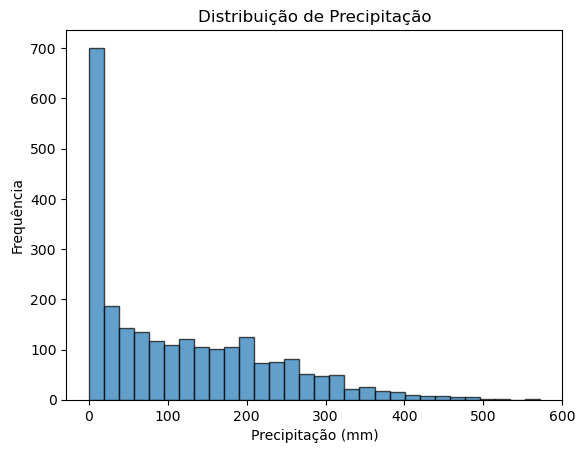

In [15]:
# Estatísticas descritivas considerando a precipitação o total diário
print(df_chuvas_analise.describe())

# Histograma
plt.hist(df_chuvas_analise['Total'], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribuição de Precipitação")
plt.xlabel("Precipitação (mm)")
plt.ylabel("Frequência")
plt.show()


In [16]:
# Verifica a qtde de registros na qual não houve precipitação, isto é, dias não chuvoso

total_registros = len(df_chuvas_analise)

# Contar o número de registros com precipitação (Total) igual a 0
registros_precipitacao_zero = len(df_chuvas_analise[df_chuvas_analise['Total'] == 0])

# Calcular o percentual de registros com precipitação igual a 0
percentual_precipitacao_zero = (registros_precipitacao_zero / total_registros) * 100

# Exibir o resultado
print(f"Percentual de dias não chuvoso: {percentual_precipitacao_zero:.2f}%")

Percentual de dias não chuvoso: 16.97%


### 2.1. Análise e remoção dos outliers

In [18]:
# Calcular o IQR para a coluna 'Total'
Q1 = df_chuvas_analise['Total'].quantile(0.25)
Q3 = df_chuvas_analise['Total'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar os outliers
outliers = df_chuvas_analise[(df_chuvas_analise['Total'] < Q1 - 1.5 * IQR) | (df_chuvas_analise['Total'] > Q3 + 1.5 * IQR)]
non_outliers = df_chuvas_analise[(df_chuvas_analise['Total'] >= Q1 - 1.5 * IQR) & (df_chuvas_analise['Total'] <= Q3 + 1.5 * IQR)]


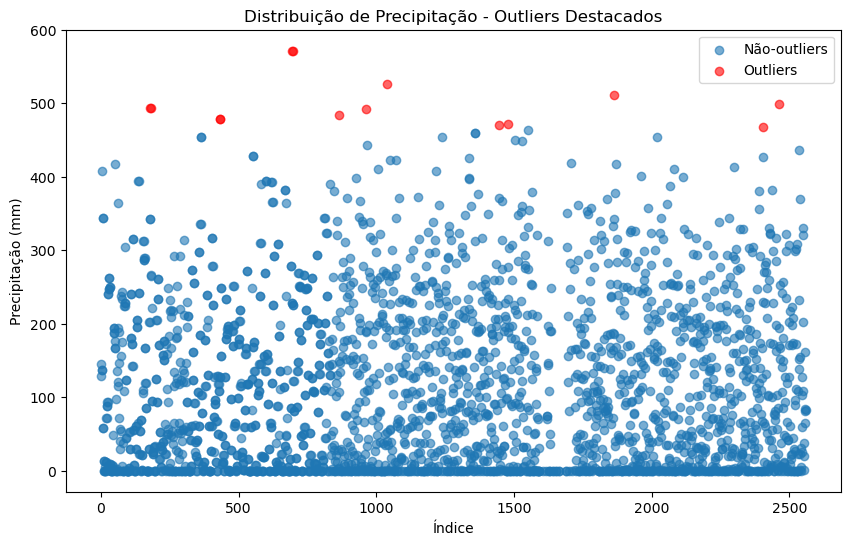

In [19]:
# Gráfico de dispersão destacando os outliers
plt.figure(figsize=(10, 6))

# Plotar dados não outliers
plt.scatter(non_outliers.index, non_outliers['Total'], label="Não-outliers", alpha=0.6)

# Plotar dados outliers em vermelho
plt.scatter(outliers.index, outliers['Total'], color='red', label="Outliers", alpha=0.6)

plt.title("Distribuição de Precipitação - Outliers Destacados")
plt.xlabel("Índice")
plt.ylabel("Precipitação (mm)")
plt.legend()
plt.show()


In [20]:
# Definir os limites inferior e superior para detecção de outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar os dados para remover outliers
df_chuvas_analise_sem_outliers = df_chuvas_analise[(df_chuvas_analise['Total'] >= limite_inferior) & (df_chuvas_analise['Total'] <= limite_superior)].copy()

# Substituir valores infinitos por NaN na coluna 'Total' diretamente usando .loc
df_chuvas_analise_sem_outliers['Total'] = df_chuvas_analise_sem_outliers['Total'].replace([np.inf, -np.inf], np.nan)

# Remover NaNs na coluna 'Total' usando inplace=True
df_chuvas_analise_sem_outliers.dropna(subset=['Total'], inplace=True)

# Exibir as formas dos DataFrames
print(df_chuvas_analise.shape)
print(df_chuvas_analise_sem_outliers.shape)


(2445, 6)
(2431, 6)


### 3. Definição e Justificativa da Distribuição a Ser Utilizada

A análise exploratória inicial do histograma dos dados de precipitação sugere que os valores podem se ajustar bem a uma **distribuição log-normal** ou **distribuição gama**. Para enriquecer o estudo e fornecer uma base de comparação, a **distribuição normal** também será considerada nas simulações de Monte Carlo, com a restrição de incluir apenas valores positivos.

A escolha das distribuições gama e log-normal se justifica pela natureza dos dados de precipitação e pelo uso comprovado dessas distribuições na modelagem de variáveis meteorológicas:

- **Distribuição Gama**: A distribuição gama é amplamente utilizada para modelar a precipitação diária e mensal, pois consegue capturar a variabilidade de intensidade das chuvas, representando com precisão tanto valores moderados quanto eventos extremos. Com um parâmetro de forma ajustável, a gama se adapta a diferentes graus de assimetria, sendo adequada para modelar eventos com alta frequência de valores baixos e alguns picos de alta intensidade. Esse comportamento é corroborado pela literatura hidrológica e meteorológica, onde a gama é comum em estudos que buscam representar padrões de precipitação, tanto para eventos médios quanto extremos.

- **Distribuição Log-Normal**: A log-normal é especialmente adequada em contextos onde eventos extremos são relevantes, como precipitações intensas e raras. Sua adequação para modelar dados positivos e assimétricos, com uma cauda longa, permite representar a probabilidade de eventos raros e de alta intensidade com eficácia. Além disso, seu uso em análises de risco de desastres naturais reforça sua aplicabilidade em cenários onde eventos extremos são de interesse.

### Avaliação das Distribuições Utilizando Simulação de Monte Carlo

As simulações de Monte Carlo para as três distribuições – log-normal, gama e normal – serão avaliadas por meio de quatro métricas principais: **Log-Likelihood (Log-Verossimilhança)**, **AIC (Akaike Information Criterion)**, **BIC (Bayesian Information Criterion)** e **Teste de Kolmogorov-Smirnov (K-S)**. Cada métrica oferece uma perspectiva única para avaliar o ajuste das distribuições:

- **Log-Likelihood**: Mede a verossimilhança dos dados observados sob cada distribuição ajustada. Quanto maior o valor da log-verossimilhança, melhor o ajuste da distribuição aos dados.
  
- **AIC e BIC**: Ambas as métricas penalizam distribuições mais complexas, favorecendo modelos que explicam bem os dados sem aumentar a complexidade desnecessariamente. O AIC é mais flexível, enquanto o BIC aplica uma penalidade mais forte para modelos com muitos parâmetros em relação ao número de observações, tornando-o útil para selecionar modelos mais parcimoniosos.
  
- **Teste de Kolmogorov-Smirnov (K-S)**: Compara a distribuição empírica dos dados com a distribuição ajustada, sendo que valores menores de KS indicam maior similaridade entre os dados observados e a distribuição escolhida.

### Consideração dos Dias Secos e Abordagem de Distribuição Mista

Observou-se que **16,9%** dos registros correspondem a dias sem precipitação (ou seja, **dias secos**). Como as distribuições log-normal e gama são adequadas apenas para valores positivos, será adotada uma **abordagem de distribuição mista** para diferenciar dias secos e dias chuvosos. Para os dias secos (precipitação zero), atribui-se uma probabilidade fixa correspondente à frequência observada; para os dias chuvosos (precipitação positiva), serão aplicadas as distribuições log-normal, gama e normal, com a normal sendo ajustada para simular apelicabilidade dos resultados.
os ao longo das estações.


### Cálculo da Média e Mediana para Cada Distribuição

A média e a mediana são calculadas de maneira específica para cada tipo de distribuição, conforme os parâmetros característicos de cada uma. Neste código, esses valores foram obtidos de forma distinta para cada distribuição, respeitando as propriedades estatísticas de cada caso.
ana diferem, enquanto na distribuição normal (simétrica), ambas são iguais.
ana diferem, enquanto na distribuição normal (simétrica), ambas são iguais.


In [23]:
def SimulacaoMonteCarlo_DistLogNormal(anum_simulacoes):
    global df_resultados

    # Substituir valores infinitos por NaN e remover linhas com NaN em 'Total'
    df_chuvas_analise_sem_outliers['Total'] = df_chuvas_analise_sem_outliers['Total'].replace([np.inf, -np.inf], np.nan)
    df_chuvas_analise_sem_outliers.dropna(subset=['Total'], inplace=True)
    
    # Separar os dias secos e chuvosos
    dias_secos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] == 0]
    dias_chuvosos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] > 0]
    
    # Probabilidade de um dia ser seco
    prob_dia_seco = len(dias_secos) / len(df_chuvas_analise_sem_outliers)
    
    # Ajuste da distribuição Log-Normal aos dias chuvosos
    shape, loc, scale = lognorm.fit(dias_chuvosos['Total'], floc=0)
    
    # Simulação de Monte Carlo
    resultados_simulacao = []
    
    for _ in range(anum_simulacoes):
        if np.random.rand() < prob_dia_seco:
            resultados_simulacao.append(0)
        else:
            chuva_simulada = lognorm.rvs(shape, loc=loc, scale=scale)
            resultados_simulacao.append(chuva_simulada)
    
    # Análise dos Resultados da Simulação
    media_simulada = np.mean(resultados_simulacao)
    mediana_simulada = np.median(resultados_simulacao)
    intervalo_5_95 = (np.percentile(resultados_simulacao, 5), np.percentile(resultados_simulacao, 95))
    
    # Média teórica e mediana teórica da log-normal
    media_teorica_logNormal = np.exp(np.log(scale) + (shape ** 2) / 2)
    mediana_teorica_logNormal = scale

    # Criar um novo DataFrame com uma linha contendo os resultados atuais
    nova_linha = pd.DataFrame({
        'TipoDistribuicao': ['Log-Normal'],
        'Shape': [shape],
        'Loc': [loc],
        'Scale': [scale],
        'Probabilidade_DiaSeco': [prob_dia_seco],
        'MediaSimulada': [media_simulada],
        'MedianaSimulada': [mediana_simulada],
        'MediaTeorica': [media_teorica_logNormal],
        'MedianaTeorica': [mediana_teorica_logNormal],
        'Intervalo_5_95': [intervalo_5_95]
    })

    # Concatenar a nova linha ao DataFrame existente
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)


    # Visualização dos Resultados
    plt.figure(figsize=(10, 5))
    sns.histplot(resultados_simulacao, kde=True)
    plt.axvline(intervalo_5_95[0], color='r', linestyle='--', label='5% Percentil')
    plt.axvline(intervalo_5_95[1], color='g', linestyle='--', label='95% Percentil')
    plt.axvline(mediana_simulada, color='b', linestyle='-', label='Mediana Simulada')
    plt.title('Simulação de Monte Carlo com Distribuição de Mistura (Binária + Log-Normal)')
    plt.xlabel('Precipitação Simulada')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

In [24]:
def SimulacaoMonteCarlo_DistGama(anum_simulacoes):
    global df_resultados
    
    # Substituir valores infinitos por NaN e remover linhas com NaN em 'Total'
    df_chuvas_analise_sem_outliers['Total'] = df_chuvas_analise_sem_outliers['Total'].replace([np.inf, -np.inf], np.nan)
    df_chuvas_analise_sem_outliers.dropna(subset=['Total'], inplace=True)
    
    # Separar os dias secos e chuvosos
    dias_secos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] == 0]
    dias_chuvosos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] > 0]
    
    # Probabilidade de um dia ser seco
    prob_dia_seco = len(dias_secos) / len(df_chuvas_analise_sem_outliers)
    
    # Ajuste da distribuição Gama aos dias chuvosos
    shape, loc, scale = gamma.fit(dias_chuvosos['Total'], floc=0)
    
    # Simulação de Monte Carlo
    resultados_simulacao = []
    
    for _ in range(anum_simulacoes):
        if np.random.rand() < prob_dia_seco:
            resultados_simulacao.append(0)
        else:
            chuva_simulada = gamma.rvs(shape, loc=loc, scale=scale)
            resultados_simulacao.append(chuva_simulada)
    
    # Análise dos Resultados da Simulação
    media_simulada = np.mean(resultados_simulacao)
    mediana_simulada = np.median(resultados_simulacao)
    intervalo_5_95 = (np.percentile(resultados_simulacao, 5), np.percentile(resultados_simulacao, 95))
    
    # Média teórica e mediana teórica da gama
    media_teorica_gama = shape * scale
    mediana_teorica_gama = gamma.median(shape, loc=loc, scale=scale)

    # Criar um novo DataFrame com uma linha contendo os resultados atuais
    nova_linha = pd.DataFrame({
        'TipoDistribuicao': ['Gama'],
        'Shape': [shape],
        'Loc': [loc],
        'Scale': [scale],
        'Probabilidade_DiaSeco': [prob_dia_seco],
        'MediaSimulada': [media_simulada],
        'MedianaSimulada': [mediana_simulada],
        'MediaTeorica': [media_teorica_gama],
        'MedianaTeorica': [mediana_teorica_gama],
        'Intervalo_5_95': [intervalo_5_95]
    })

    # Concatenar a nova linha ao DataFrame existente
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)


    # Visualização dos Resultados
    plt.figure(figsize=(10, 5))
    sns.histplot(resultados_simulacao, kde=True)
    plt.axvline(intervalo_5_95[0], color='r', linestyle='--', label='5% Percentil')
    plt.axvline(intervalo_5_95[1], color='g', linestyle='--', label='95% Percentil')
    plt.axvline(mediana_simulada, color='b', linestyle='-', label='Mediana Simulada')
    plt.title('Simulação de Monte Carlo com Distribuição de Mistura (Binária + Gama)')
    plt.xlabel('Precipitação Simulada')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

In [25]:
def SimulacaoMonteCarlo_DistNormal(anum_simulacoes):
    global df_resultados  # Declarar df_resultados como global para ser acessível fora da função
    

    # Substituir valores infinitos por NaN e remover linhas com NaN em 'Total'
    df_chuvas_analise_sem_outliers['Total'] = df_chuvas_analise_sem_outliers['Total'].replace([np.inf, -np.inf], np.nan)
    df_chuvas_analise_sem_outliers.dropna(subset=['Total'], inplace=True)
    
    # Separar os dias secos e chuvosos
    dias_secos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] == 0]
    dias_chuvosos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] > 0]
    
    # Verificar se há dados suficientes em dias_chuvosos para ajustar a distribuição
    if dias_chuvosos.empty:
        print("Não há dados suficientes de dias chuvosos com valores positivos para ajustar a distribuição.")
        return
    
    # Probabilidade de um dia ser seco
    prob_dia_seco = len(dias_secos) / len(df_chuvas_analise_sem_outliers)
    
    # Ajuste da distribuição Normal aos dias chuvosos (valores positivos)
    mean, std_dev = norm.fit(dias_chuvosos['Total'])
    
    # Simulação de Monte Carlo
    resultados_simulacao = []
    
    for _ in range(anum_simulacoes):
        if np.random.rand() < prob_dia_seco:
            resultados_simulacao.append(0)
        else:
            # Garantir valores positivos simulando até obter um positivo
            chuva_simulada = norm.rvs(loc=mean, scale=std_dev)
            while chuva_simulada <= 0:
                chuva_simulada = norm.rvs(loc=mean, scale=std_dev)
            resultados_simulacao.append(chuva_simulada)
    
    # Análise dos Resultados da Simulação
    media_simulada = np.mean(resultados_simulacao)
    mediana_simulada = np.median(resultados_simulacao)
    intervalo_5_95 = (np.percentile(resultados_simulacao, 5), np.percentile(resultados_simulacao, 95))
    
    # Média teórica e mediana teórica da normal
    media_teorica_normal = mean
    mediana_teorica_normal = mean

    # Criar um novo DataFrame com uma linha contendo os resultados atuais
    nova_linha = pd.DataFrame({
        'TipoDistribuicao': ['Normal (Positivos)'],
        'Mean': [mean],
        'StdDev': [std_dev],
        'Probabilidade_DiaSeco': [prob_dia_seco],
        'MediaSimulada': [media_simulada],
        'MedianaSimulada': [mediana_simulada],
        'MediaTeorica': [media_teorica_normal],
        'MedianaTeorica': [mediana_teorica_normal],
        'Intervalo_5_95': [intervalo_5_95]
    })

    # Concatenar a nova linha ao DataFrame existente, se não estiver vazia ou toda NaN
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        df_resultados = pd.concat([df_resultados, nova_linha], ignore_index=True)

    # Visualização dos Resultados
    plt.figure(figsize=(10, 5))
    sns.histplot(resultados_simulacao, kde=True)
    plt.axvline(intervalo_5_95[0], color='r', linestyle='--', label='5% Percentil')
    plt.axvline(intervalo_5_95[1], color='g', linestyle='--', label='95% Percentil')
    plt.axvline(mediana_simulada, color='b', linestyle='-', label='Mediana Simulada')
    plt.title('Simulação de Monte Carlo com Distribuição de Mistura (Binária + Normal com valores Positivos)')
    plt.xlabel('Precipitação Simulada')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()


In [26]:
def AvaliarSimulacoes():
    global df_resultados  # Declarar df_resultados como global para ser acessível fora da função

    dias_chuvosos = df_chuvas_analise_sem_outliers.loc[df_chuvas_analise_sem_outliers['Total'] > 0]
    
    # Filtrar resultados para as distribuições log-normal, gama e normal
    log_normal_params = df_resultados[df_resultados['TipoDistribuicao'] == 'Log-Normal'].iloc[0]
    gamma_params = df_resultados[df_resultados['TipoDistribuicao'] == 'Gama'].iloc[0]
    normal_params = df_resultados[df_resultados['TipoDistribuicao'] == 'Normal (Positivos)'].iloc[0]
    
    # 1. Calcular a log-verossimilhança de cada distribuição
    log_likelihood_ln = np.sum(lognorm.logpdf(dias_chuvosos['Total'], 
                                              log_normal_params['Shape'], 
                                              loc=log_normal_params['Loc'], 
                                              scale=log_normal_params['Scale']))
    
    log_likelihood_g = np.sum(gamma.logpdf(dias_chuvosos['Total'], 
                                           gamma_params['Shape'], 
                                           loc=gamma_params['Loc'], 
                                           scale=gamma_params['Scale']))
    
    log_likelihood_norm = np.sum(norm.logpdf(dias_chuvosos['Total'], 
                                             loc=normal_params['Mean'], 
                                             scale=normal_params['StdDev']))
    
    # 2. Calcular AIC e BIC para cada distribuição
    n = len(dias_chuvosos['Total'])  # Número de observações
    
    # AIC = 2 * k - 2 * log-likelihood, onde k é o número de parâmetros
    aic_ln = 2 * 3 - 2 * log_likelihood_ln  # 3 parâmetros para log-normal
    aic_g = 2 * 3 - 2 * log_likelihood_g    # 3 parâmetros para gama
    aic_norm = 2 * 2 - 2 * log_likelihood_norm  # 2 parâmetros para normal
    
    # BIC = k * ln(n) - 2 * log-likelihood
    bic_ln = 3 * np.log(n) - 2 * log_likelihood_ln
    bic_g = 3 * np.log(n) - 2 * log_likelihood_g
    bic_norm = 2 * np.log(n) - 2 * log_likelihood_norm
    
    # 3. Teste de Kolmogorov-Smirnov (K-S) para cada distribuição
    ks_stat_ln, p_value_ln = kstest(dias_chuvosos['Total'], 'lognorm', args=(log_normal_params['Shape'], 
                                                                             log_normal_params['Loc'], 
                                                                             log_normal_params['Scale']))
    
    ks_stat_g, p_value_g = kstest(dias_chuvosos['Total'], 'gamma', args=(gamma_params['Shape'], 
                                                                         gamma_params['Loc'], 
                                                                         gamma_params['Scale']))
    
    ks_stat_norm, p_value_norm = kstest(dias_chuvosos['Total'], 'norm', args=(normal_params['Mean'], 
                                                                              normal_params['StdDev']))
    
    # Adicionar as colunas ao DataFrame `df_resultados`
    df_resultados.loc[df_resultados['TipoDistribuicao'] == 'Log-Normal', ['LogLikelihood', 'AIC', 'BIC', 'KS_Stat', 'KS_pValue']] = [
        log_likelihood_ln, aic_ln, bic_ln, ks_stat_ln, p_value_ln
    ]
    df_resultados.loc[df_resultados['TipoDistribuicao'] == 'Gama', ['LogLikelihood', 'AIC', 'BIC', 'KS_Stat', 'KS_pValue']] = [
        log_likelihood_g, aic_g, bic_g, ks_stat_g, p_value_g
    ]
    df_resultados.loc[df_resultados['TipoDistribuicao'] == 'Normal (Positivos)', ['LogLikelihood', 'AIC', 'BIC', 'KS_Stat', 'KS_pValue']] = [
        log_likelihood_norm, aic_norm, bic_norm, ks_stat_norm, p_value_norm
    ]


In [27]:
def ExibirMelhorDistribuicao():
    # Ordenar o DataFrame por cada métrica e selecionar as três melhores
    top_log_likelihood = df_resultados[['TipoDistribuicao', 'LogLikelihood']].sort_values(by='LogLikelihood', ascending=False).head(3).reset_index(drop=True)
    top_aic = df_resultados[['TipoDistribuicao', 'AIC']].sort_values(by='AIC').head(3).reset_index(drop=True)
    top_bic = df_resultados[['TipoDistribuicao', 'BIC']].sort_values(by='BIC').head(3).reset_index(drop=True)
    top_ks = df_resultados[['TipoDistribuicao', 'KS_Stat', 'KS_pValue']].sort_values(by='KS_Stat').head(3).reset_index(drop=True)

    # Exibir os resultados
    print(f"Melhores Distribuições por Métrica para {TotalSimulacoes} simulações")
    print("---------------------------------")
    
    print("Log-Likelihood (maior é melhor):")
    for i, row in top_log_likelihood.iterrows():
        print(f"{i+1}º: {row['TipoDistribuicao']} (Log-Likelihood = {row['LogLikelihood']})")
    print()
    
    print("AIC (menor é melhor):")
    for i, row in top_aic.iterrows():
        print(f"{i+1}º: {row['TipoDistribuicao']} (AIC = {row['AIC']})")
    print()
    
    print("BIC (menor é melhor):")
    for i, row in top_bic.iterrows():
        print(f"{i+1}º: {row['TipoDistribuicao']} (BIC = {row['BIC']})")
    print()
    
    print("K-S Test (menor KS_Stat é melhor):")
    for i, row in top_ks.iterrows():
        print(f"{i+1}º: {row['TipoDistribuicao']} (KS_Stat = {row['KS_Stat']}, p-value = {row['KS_pValue']})")


C:\Users\aqcor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


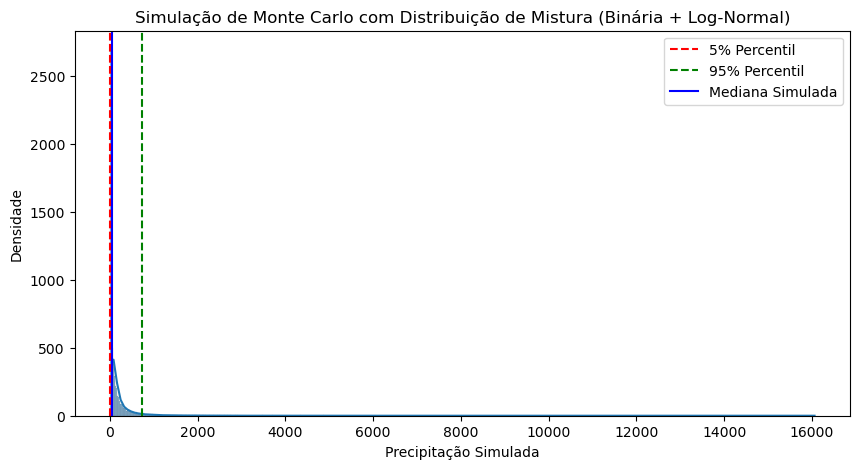

C:\Users\aqcor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


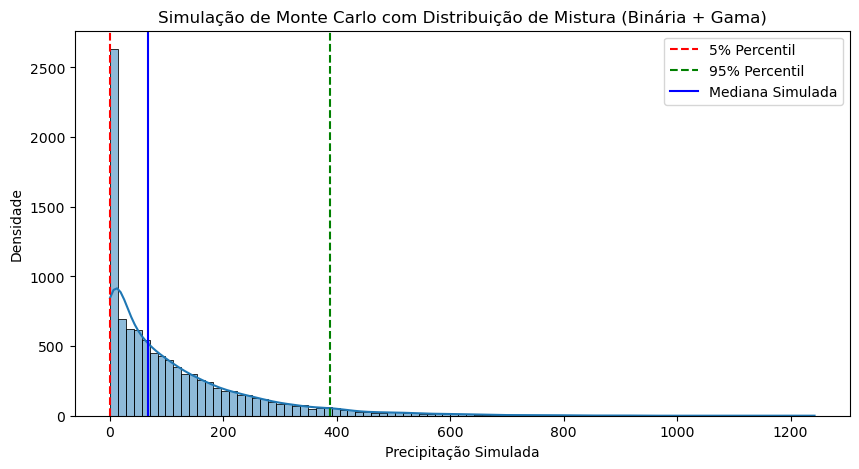

C:\Users\aqcor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


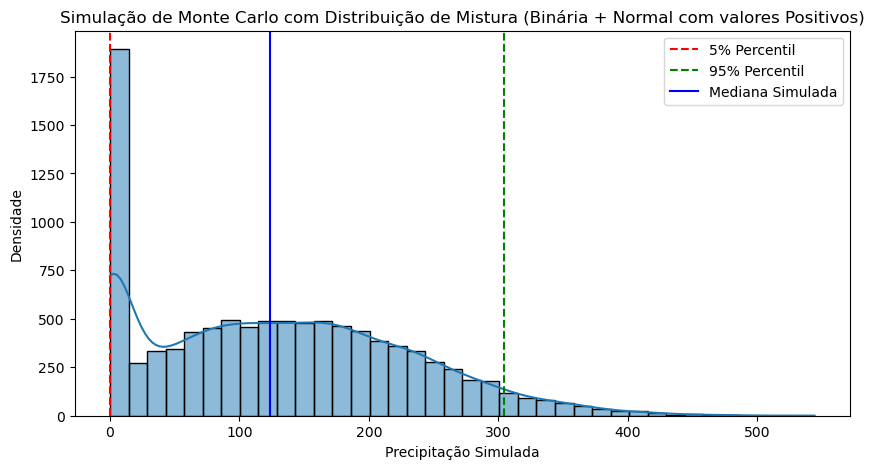

Melhores Distribuições por Métrica para 10000 simulações
---------------------------------
Log-Likelihood (maior é melhor):
1º: Gama (Log-Likelihood = -11913.893699617893)
2º: Normal (Positivos) (Log-Likelihood = -12259.055525629381)
3º: Log-Normal (Log-Likelihood = -12353.250295793752)

AIC (menor é melhor):
1º: Gama (AIC = 23833.787399235785)
2º: Normal (Positivos) (AIC = 24522.111051258762)
3º: Log-Normal (AIC = 24712.500591587504)

BIC (menor é melhor):
1º: Gama (BIC = 23850.614011123358)
2º: Normal (Positivos) (BIC = 24533.328792517146)
3º: Log-Normal (BIC = 24729.327203475077)

K-S Test (menor KS_Stat é melhor):
1º: Gama (KS_Stat = 0.09192523509151668, p-value = 2.8251984718370067e-15)
2º: Normal (Positivos) (KS_Stat = 0.10022328224747817, p-value = 4.419369766856157e-18)
3º: Log-Normal (KS_Stat = 0.1390523658908393, p-value = 1.8166644104155463e-34)


In [28]:
# Informar o total de simulações a ser realizada
TotalSimulacoes = 10000

df_resultados = pd.DataFrame(columns=[
    'TipoDistribuicao', 'Shape', 'Loc', 'Scale', 'Probabilidade_DiaSeco',
    'MediaSimulada', 'MedianaSimulada', 'MediaTeorica', 'MedianaTeorica', 'Intervalo_5_95'
])

# Realiza simulacoes
SimulacaoMonteCarlo_DistLogNormal(TotalSimulacoes)
SimulacaoMonteCarlo_DistGama(TotalSimulacoes)
SimulacaoMonteCarlo_DistNormal(TotalSimulacoes)

# Avalia os resultados
AvaliarSimulacoes()

# Imprime a melhor distribuicao com base na analise do resultado das métricas
ExibirMelhorDistribuicao()

In [29]:
# Imprime resultado
df_resultados.head()

,TipoDistribuicao,Shape,Loc,Scale,Probabilidade_DiaSeco,MediaSimulada,MedianaSimulada,MediaTeorica,MedianaTeorica,Intervalo_5_95,Mean,StdDev,LogLikelihood,AIC,BIC,KS_Stat,KS_pValue
0,Log-Normal,1.472452,0,75.319345,0.170712,184.311701,50.307576,222.692940,75.319345,"(0.0, 734.4610306473725)",NaN,NaN,-12353.250296,24712.500592,24729.327203,0.139052,1.816664e-34
1,Gama,0.983544,0,137.875542,0.170712,112.480770,66.789712,135.606721,93.373084,"(0.0, 387.66192329717006)",NaN,NaN,-11913.893700,23833.787399,23850.614011,0.091925,2.825198e-15
2,Normal (Positivos),NaN,NaN,NaN,0.170712,129.969165,123.359798,135.606721,135.606721,"(0.0, 304.59018579557625)",135.606721,105.841446,-12259.055526,24522.111051,24533.328793,0.100223,4.419370e-18


### 4. Conclusão

As métricas de ajuste indicaram que a **distribuição gama** é a que melhor se adapta aos dados de precipitação, seguida pela **distribuição normal** e, por último, pela **distribuição log-normal**. A distribuição gama mostrou-se mais eficaz em capturar a variabilidade e intensidade dos eventos de precipitação, especialmente em termos de valores medianos e extremos.

### Considerações sobre Sazonalidade

Este estudo não levou em conta a **sazonalidade**, ou seja, as variações significativas na precipitação ao longo do ano. Em análises futuras, uma abordagem mais detalhada poderia considerar a sazonalidade nos dados pluviométricos, ajustando a modelagem para refletir a variabilidade entre estações e meses. Essa adaptação permitiria o uso de diferentes distribuições para distintos períodos do ano, capturando as mudanças sazonais na intensidade e frequência das chuvas.

Com essa metodologia, seria possível desenvolver um modelo ainda mais preciso, capaz de representar padrões de precipitação específicos de cada época do ano, aprimorando a adequação e a aplicabilidade dos resultados ao longo das diferentes estações.
